In [1]:
from labellines import labelLines
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

matplotlib.rc("font", size=16)
plt.style.use("tableau-colorblind10")

In [2]:
df = pd.read_excel("rmse_data.xlsx", index_col=0)
n_samples = df.samples.unique()
ortho_data = []
ortho_means = []
non_ortho_data = []
for samples in n_samples:
    slice_df = df[df.samples == samples]
    ortho_data.append(slice_df.ortho)
    ortho_means.append(slice_df.ortho.mean())
    non_ortho_data.append(slice_df.non_ortho)

full data set: $y=15.2067x^{-0.47710}$, $R^2={0.9825}$
truncated dataset: $y=14.3905x^{-0.48797}$, $R^2={0.9992}$


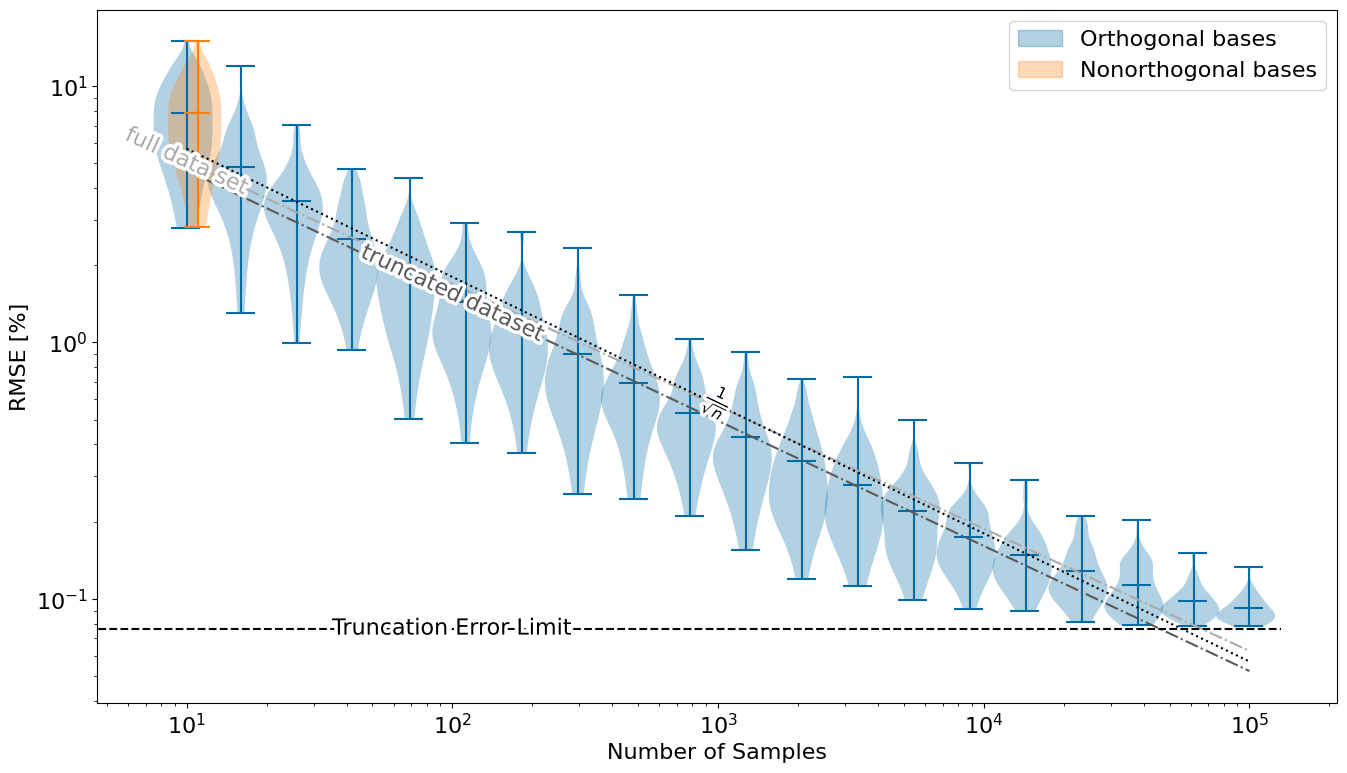

In [19]:
O_14_LIMIT = 0.07651166303158025

# from SO
labels = []
def add_label(violin, label):
    if isinstance(violin, dict):
        color = violin["bodies"][0].get_facecolor().flatten()
    else:
        color = violin[0].get_color()

    labels.append((mpatches.Patch(color=color), label))
plt.figure(figsize=(16,9))
add_label(plt.violinplot(ortho_data, n_samples, showmeans=True, widths = [0.5 * samples for samples in n_samples]), "Orthogonal bases")
add_label(plt.violinplot(non_ortho_data[0:1], n_samples[0:1] * 1.1, showmeans=True, widths = 5), label="Nonorthogonal bases")

def power_law(x, a, b):
    return a*x + b

sub_slice = slice(4, -5)
for name, (xdata, ydata) in {"full data set": (n_samples, ortho_means), "truncated dataset": (n_samples[sub_slice], ortho_means[sub_slice])}.items():
    #regression
    params, _ = curve_fit(power_law, np.log(xdata), np.log(ydata))
    a, b = params
    bound = lambda x: power_law(x, *params)
    
    residuals = np.log(ydata) - bound(np.log(xdata))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((np.log(ydata) - np.mean(np.log(ydata)))**2)
    r_sq = 1 - ss_res / ss_tot
    
    print(f"{name}: $y={np.exp(b):.4f}x^{{{a:.5f}}}$, $R^2={{{r_sq:.4f}}}$")
    plt.plot(n_samples, np.exp(bound(np.log(n_samples))), "-.", label=name)
plt.plot(plt.xlim(),[O_14_LIMIT]*2,  "k--", label="Truncation Error Limit")
plt.plot(n_samples, 1/np.sqrt(n_samples) * 18, "k:", label=r"$\frac{1}{\sqrt{n}}$")
labelLines(plt.gca().get_lines(), xvals=[10,100,100,1e3])
plt.legend(*zip(*labels))
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel("Number of Samples")
plt.ylabel("RMSE [%]")
#plt.ylim((0.05, 20))
for ext in {"pdf", "png", "svg"}:
    plt.savefig(f"samples.{ext}")